In [1]:
#!pip install -U flwr["simulation"]==1.9.0 torch torchvision GPUtil

In [2]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, NamedTuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import time
import flwr as fl
from scipy import stats as st
import json

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.3.1 and Flower 1.9.0


In [3]:
from logging import INFO, DEBUG
from flwr.common.logger import log

In [4]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
   process = psutil.Process(os.getpid())
   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 120.7 GB  | Proc size: 515.6 MB
GPU RAM Free: 15289MB | Used: 881MB | Util   5% | Total 16376MB


In [5]:
NUM_CLIENTS = 10


def load_datasets(num_clients: int):
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR10("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR10("./dataset", train=False, download=True, transform=transform)

    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * num_clients
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=32, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=32))
    testloader = DataLoader(testset, batch_size=32)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

class ClientMetrics(NamedTuple):
    epoch: int
    loss: float
    accuracy: float
    round: int = 0
    cid: int = 0

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    metrics = []
    for epoch in range(epochs):  # Use the passed 'epochs' variable here
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()  # Make sure to call .item() to get the scalar value
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        metrics.append(ClientMetrics(epoch, epoch_loss, epoch_acc))
        print(f"Epoch {epoch}: train loss {epoch_loss:.6f}, accuracy {epoch_acc:.6f}")
        
    return metrics


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [7]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        epochs = config.get("epochs", 1)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs)
        training_time = time.time() - start_time  # Calculate duration
        print(f"Training time for Client {self.cid}: {training_time:.2f} seconds")
        
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}



    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [8]:
from typing import Callable, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


class FedCustom(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}
    def __repr__(self) -> str:
        return "FedCustom"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return fl.common.ndarrays_to_parameters(ndarrays)

    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager):
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        epochs_sc = 10
        

        standard_config = {"lr": 0.001, "epochs": epochs_sc}
        
        fit_configurations = []
        mode_time = []
        
        for client in clients:
            last_time = self.client_training_times.get(client.cid, [0,])[-1] # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is ths last time not a fantasy {last_time}and {client.cid}habhhahah")
            
            
            mode_time.append(round(last_time,2))
            print(f"this is tehb mode time {mode_time}")
           

        modest_value = st.mode(np.array(mode_time))
        print(f"Yeh h modest valueueueueu{modest_value}")
        print(f"yeh h server round {server_round}")
        min_value, max_value= np.min(modest_value),np.max(modest_value)
        print(f"this is the min value {min_value} and this is the max value {max_value}")
      
        
        if min_value == max_value:
            epochs_hl = epochs_sc   
        else:
            epochs_hl = int(np.floor((max_value-min_value)/max_value * epochs_sc)) 

        higher_lr_config = {"lr": 0.0001, "epochs": epochs_hl}
        print(f"The epochs for the higher lr is {epochs_hl} and the epochs for the standard lr is {epochs_sc}")




        for client in clients:
            # Choose config based on the previous training time
            last_time = self.client_training_times.get(client.cid, [0,])[-1]  # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is the last time {last_time}")
            


            config_to_use = standard_config if last_time < modest_value.mode else higher_lr_config
            fit_configurations.append((client, FitIns(parameters, config_to_use)))

        return fit_configurations
    
    def parse_metrics(self, cid: int, server_round: int, metrics: str): # this function has been added to parse the metrics from the client
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            # Update training times for each client
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0)) # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            self.parse_metrics(client.cid,server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated


    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evalua
        tion function."""

        # Let's assume we won't perform the global model evaluation on the server side.
        
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

In [9]:
if DEVICE.type == "cuda":
    # Use a single client to train the global model
    client_resources = {"num_gpus": .125, "num_cpus": 1} 

In [10]:
strategy = FedCustom()
#fl.common.logger.configure(identifier="myflExpMY", filename="FLLOG_my.txt")
history = fl.simulation.start_simulation(client_fn=client_fn,
                                         num_clients=10,
                                         config=fl.server.ServerConfig(num_rounds=10),
                                         strategy=strategy,  # <-- pass the new strategy here
                                         client_resources=client_resources,

)
history


INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-29 10:07:15,809	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'memory': 74253956506.0, 'node:127.0.0.1': 1.0, 'accelerator_type:RTX': 1.0, 'GPU': 1.0, 'object_store_memory': 36108838502.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 0and 4habhhahah
this is tehb mode time [0]
This is ths last time not a fantasy 0and 7habhhahah
this is tehb mode time [0, 0]
This is ths last time not a fantasy 0and 6habhhahah
this is tehb mode time [0, 0, 0]
This is ths last time not a fantasy 0and 3habhhahah
this is tehb mode time [0, 0, 0, 0]
This is ths last time not a fantasy 0and 0habhhahah
this is tehb mode time [0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 9habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 2habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 5habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 1habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 8habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Yeh h modest valueueueueuModeResult(mode=0, count=10)
yeh h server round 1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=36268) Epoch 9: train loss 0.036810, accuracy 0.568889 [repeated 5x across cluster]
(ClientAppActor pid=36268) [Client 5] evaluate, config: {}
(ClientAppActor pid=36268) Training time for Client 8: 23.16 seconds
(ClientAppActor pid=36268) [Client 8] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 21.94222664833069and 4habhhahah
this is tehb mode time [21.94]
This is ths last time not a fantasy 22.3122980594635and 2habhhahah
this is tehb mode time [21.94, 22.31]
This is ths last time not a fantasy 22.497130393981934and 7habhhahah
this is tehb mode time [21.94, 22.31, 22.5]
This is ths last time not a fantasy 22.549426794052124and 5habhhahah
this is tehb mode time [21.94, 22.31, 22.5, 22.55]
This is ths last time not a fantasy 22.557677268981934and 6habhhahah
this is tehb mode time [21.94, 22.31, 22.5, 22.55, 22.56]
This is ths last time not a fantasy 23.16368842124939and 8habhhahah
this is tehb mode time [21.94, 22.31, 22.5, 22.55, 22.56, 23.16]
This is ths last time not a fantasy 22.509782791137695and 3habhhahah
this is tehb mode time [21.94, 22.31, 22.5, 22.55, 22.56, 23.16, 22.51]
This is ths last time not a fantasy 23.607501745224and 1habhhahah
this is tehb mode time [21.94, 22.31, 22.5, 22.55, 22.56, 23.16, 22.51, 23.61]
This is ths last 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=13852) [Client 8] evaluate, config: {}
(ClientAppActor pid=13852) Epoch 8: train loss 0.026368, accuracy 0.705111 [repeated 2x across cluster]
(ClientAppActor pid=13852) Training time for Client 0: 20.78 seconds
(ClientAppActor pid=19292) [Client 3] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 19.7057523727417and 5habhhahah
this is tehb mode time [19.71]
This is ths last time not a fantasy 20.815473556518555and 9habhhahah
this is tehb mode time [19.71, 20.82]
This is ths last time not a fantasy 19.609206199645996and 7habhhahah
this is tehb mode time [19.71, 20.82, 19.61]
This is ths last time not a fantasy 20.776824474334717and 0habhhahah
this is tehb mode time [19.71, 20.82, 19.61, 20.78]
This is ths last time not a fantasy 19.936753034591675and 4habhhahah
this is tehb mode time [19.71, 20.82, 19.61, 20.78, 19.94]
This is ths last time not a fantasy 19.74629020690918and 3habhhahah
this is tehb mode time [19.71, 20.82, 19.61, 20.78, 19.94, 19.75]
This is ths last time not a fantasy 20.13460659980774and 1habhhahah
this is tehb mode time [19.71, 20.82, 19.61, 20.78, 19.94, 19.75, 20.13]
This is ths last time not a fantasy 20.40073585510254and 2habhhahah
this is tehb mode time [19.71, 20.82, 19.61, 20.78, 19.94, 19.75, 20.13, 20.4]
This is th

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=13852) [Client 8] evaluate, config: {}
(ClientAppActor pid=13852) Epoch 8: train loss 0.014378, accuracy 0.840000 [repeated 2x across cluster]
(ClientAppActor pid=13852) Training time for Client 8: 21.03 seconds
(ClientAppActor pid=20448) [Client 4] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 19.954402923583984and 1habhhahah
this is tehb mode time [19.95]
This is ths last time not a fantasy 20.16603446006775and 3habhhahah
this is tehb mode time [19.95, 20.17]
This is ths last time not a fantasy 20.936359405517578and 6habhhahah
this is tehb mode time [19.95, 20.17, 20.94]
This is ths last time not a fantasy 20.61971640586853and 5habhhahah
this is tehb mode time [19.95, 20.17, 20.94, 20.62]
This is ths last time not a fantasy 22.18703532218933and 7habhhahah
this is tehb mode time [19.95, 20.17, 20.94, 20.62, 22.19]
This is ths last time not a fantasy 20.19159770011902and 0habhhahah
this is tehb mode time [19.95, 20.17, 20.94, 20.62, 22.19, 20.19]
This is ths last time not a fantasy 19.55391836166382and 2habhhahah
this is tehb mode time [19.95, 20.17, 20.94, 20.62, 22.19, 20.19, 19.55]
This is ths last time not a fantasy 20.115633726119995and 9habhhahah
this is tehb mode time [19.95, 20.17, 20.94, 20.62, 22.19, 20.19, 19.55, 20.12]
This is t

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=19292) [Client 9] evaluate, config: {}
(ClientAppActor pid=19292) Epoch 8: train loss 0.006742, accuracy 0.932222 [repeated 2x across cluster]
(ClientAppActor pid=19292) Training time for Client 8: 20.93 seconds
(ClientAppActor pid=13852) [Client 8] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 19.6811203956604and 6habhhahah
this is tehb mode time [19.68]
This is ths last time not a fantasy 20.315114498138428and 3habhhahah
this is tehb mode time [19.68, 20.32]
This is ths last time not a fantasy 19.596726655960083and 0habhhahah
this is tehb mode time [19.68, 20.32, 19.6]
This is ths last time not a fantasy 19.445284843444824and 9habhhahah
this is tehb mode time [19.68, 20.32, 19.6, 19.45]
This is ths last time not a fantasy 20.30324912071228and 7habhhahah
this is tehb mode time [19.68, 20.32, 19.6, 19.45, 20.3]
This is ths last time not a fantasy 20.08194351196289and 5habhhahah
this is tehb mode time [19.68, 20.32, 19.6, 19.45, 20.3, 20.08]
This is ths last time not a fantasy 20.927738904953003and 8habhhahah
this is tehb mode time [19.68, 20.32, 19.6, 19.45, 20.3, 20.08, 20.93]
This is ths last time not a fantasy 20.734645128250122and 4habhhahah
this is tehb mode time [19.68, 20.32, 19.6, 19.45, 20.3, 20.08, 20.93, 20.73]
This is ths last t

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=20512) [Client 3] evaluate, config: {}
(ClientAppActor pid=20512) Training time for Client 2: 21.41 seconds
(ClientAppActor pid=20512) Epoch 8: train loss 0.003643, accuracy 0.971111
(ClientAppActor pid=20512) [Client 5] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.610188722610474and 7habhhahah
this is tehb mode time [20.61]
This is ths last time not a fantasy 19.7183256149292and 5habhhahah
this is tehb mode time [20.61, 19.72]
This is ths last time not a fantasy 20.446873903274536and 4habhhahah
this is tehb mode time [20.61, 19.72, 20.45]
This is ths last time not a fantasy 19.963398694992065and 3habhhahah
this is tehb mode time [20.61, 19.72, 20.45, 19.96]
This is ths last time not a fantasy 20.118391036987305and 6habhhahah
this is tehb mode time [20.61, 19.72, 20.45, 19.96, 20.12]
This is ths last time not a fantasy 21.24259090423584and 1habhhahah
this is tehb mode time [20.61, 19.72, 20.45, 19.96, 20.12, 21.24]
This is ths last time not a fantasy 21.411941289901733and 2habhhahah
this is tehb mode time [20.61, 19.72, 20.45, 19.96, 20.12, 21.24, 21.41]
This is ths last time not a fantasy 20.465471744537354and 0habhhahah
this is tehb mode time [20.61, 19.72, 20.45, 19.96, 20.12, 21.24, 21.41, 20.47]
This is

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=13852) [Client 3] evaluate, config: {}
(ClientAppActor pid=13852) Epoch 8: train loss 0.003875, accuracy 0.962667 [repeated 2x across cluster]
(ClientAppActor pid=13852) Training time for Client 8: 21.09 seconds
(ClientAppActor pid=26532) [Client 2] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.215144872665405and 6habhhahah
this is tehb mode time [20.22]
This is ths last time not a fantasy 19.82829213142395and 2habhhahah
this is tehb mode time [20.22, 19.83]
This is ths last time not a fantasy 20.590498685836792and 0habhhahah
this is tehb mode time [20.22, 19.83, 20.59]
This is ths last time not a fantasy 20.12330150604248and 1habhhahah
this is tehb mode time [20.22, 19.83, 20.59, 20.12]
This is ths last time not a fantasy 20.90249729156494and 9habhhahah
this is tehb mode time [20.22, 19.83, 20.59, 20.12, 20.9]
This is ths last time not a fantasy 22.931498050689697and 5habhhahah
this is tehb mode time [20.22, 19.83, 20.59, 20.12, 20.9, 22.93]
This is ths last time not a fantasy 20.223010301589966and 4habhhahah
this is tehb mode time [20.22, 19.83, 20.59, 20.12, 20.9, 22.93, 20.22]
This is ths last time not a fantasy 20.998979806900024and 7habhhahah
this is tehb mode time [20.22, 19.83, 20.59, 20.12, 20.9, 22.93, 20.22, 21.0]
This is ths 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=26892) Epoch 9: train loss 0.003098, accuracy 0.973556 [repeated 5x across cluster]
(ClientAppActor pid=26892) [Client 1] evaluate, config: {}
(ClientAppActor pid=26892) Training time for Client 3: 23.98 seconds
(ClientAppActor pid=13852) [Client 9] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.267523527145386and 5habhhahah
this is tehb mode time [20.27]
This is ths last time not a fantasy 20.4159893989563and 7habhhahah
this is tehb mode time [20.27, 20.42]
This is ths last time not a fantasy 21.675060272216797and 8habhhahah
this is tehb mode time [20.27, 20.42, 21.68]
This is ths last time not a fantasy 20.056414365768433and 9habhhahah
this is tehb mode time [20.27, 20.42, 21.68, 20.06]
This is ths last time not a fantasy 22.144381999969482and 2habhhahah
this is tehb mode time [20.27, 20.42, 21.68, 20.06, 22.14]
This is ths last time not a fantasy 20.14652109146118and 4habhhahah
this is tehb mode time [20.27, 20.42, 21.68, 20.06, 22.14, 20.15]
This is ths last time not a fantasy 22.24926996231079and 1habhhahah
this is tehb mode time [20.27, 20.42, 21.68, 20.06, 22.14, 20.15, 22.25]
This is ths last time not a fantasy 20.126712799072266and 0habhhahah
this is tehb mode time [20.27, 20.42, 21.68, 20.06, 22.14, 20.15, 22.25, 20.13]
This is 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=26892) [Client 9] evaluate, config: {}
(ClientAppActor pid=26892) Epoch 8: train loss 0.002809, accuracy 0.972889 [repeated 2x across cluster]
(ClientAppActor pid=26892) Training time for Client 3: 20.63 seconds
(ClientAppActor pid=36268) [Client 1] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 19.928953170776367and 7habhhahah
this is tehb mode time [19.93]
This is ths last time not a fantasy 21.960375547409058and 9habhhahah
this is tehb mode time [19.93, 21.96]
This is ths last time not a fantasy 19.17721700668335and 2habhhahah
this is tehb mode time [19.93, 21.96, 19.18]
This is ths last time not a fantasy 19.835459232330322and 4habhhahah
this is tehb mode time [19.93, 21.96, 19.18, 19.84]
This is ths last time not a fantasy 20.1494619846344and 1habhhahah
this is tehb mode time [19.93, 21.96, 19.18, 19.84, 20.15]
This is ths last time not a fantasy 20.29205846786499and 6habhhahah
this is tehb mode time [19.93, 21.96, 19.18, 19.84, 20.15, 20.29]
This is ths last time not a fantasy 20.256851196289062and 8habhhahah
this is tehb mode time [19.93, 21.96, 19.18, 19.84, 20.15, 20.29, 20.26]
This is ths last time not a fantasy 19.984837770462036and 0habhhahah
this is tehb mode time [19.93, 21.96, 19.18, 19.84, 20.15, 20.29, 20.26, 19.98]
This is 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=36268) [Client 1] evaluate, config: {}
(ClientAppActor pid=36268) Training time for Client 5: 20.39 seconds
(ClientAppActor pid=36268) Epoch 8: train loss 0.000444, accuracy 0.999778
(ClientAppActor pid=19292) [Client 7] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.39993381500244and 9habhhahah
this is tehb mode time [20.4]
This is ths last time not a fantasy 19.98620319366455and 7habhhahah
this is tehb mode time [20.4, 19.99]
This is ths last time not a fantasy 22.06397771835327and 2habhhahah
this is tehb mode time [20.4, 19.99, 22.06]
This is ths last time not a fantasy 20.221181869506836and 3habhhahah
this is tehb mode time [20.4, 19.99, 22.06, 20.22]
This is ths last time not a fantasy 20.45430088043213and 4habhhahah
this is tehb mode time [20.4, 19.99, 22.06, 20.22, 20.45]
This is ths last time not a fantasy 20.53438949584961and 0habhhahah
this is tehb mode time [20.4, 19.99, 22.06, 20.22, 20.45, 20.53]
This is ths last time not a fantasy 20.104477882385254and 1habhhahah
this is tehb mode time [20.4, 19.99, 22.06, 20.22, 20.45, 20.53, 20.1]
This is ths last time not a fantasy 19.71949863433838and 8habhhahah
this is tehb mode time [20.4, 19.99, 22.06, 20.22, 20.45, 20.53, 20.1, 19.72]
This is ths last tim

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=19292) [Client 6] evaluate, config: {}
(ClientAppActor pid=19292) Epoch 8: train loss 0.006805, accuracy 0.927333 [repeated 2x across cluster]
(ClientAppActor pid=19292) Training time for Client 6: 20.40 seconds
(ClientAppActor pid=13852) [Client 0] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 589.74s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.055380082559585576
INFO :      		round 2: 0.04292244457006454
INFO :      		round 3: 0.04645359140634537
INFO :      		round 4: 0.05351695886850357
INFO :      		round 5: 0.060426591074466705
INFO :      		round 6: 0.06714729952812196
INFO :      		round 7: 0.0695942828655243
INFO :      		round 8: 0.0722857114315033
INFO :      		round 9: 0.07900095813274384
INFO :      		round 10: 0.07770004682540894
INFO :      


History (loss, distributed):
	round 1: 0.055380082559585576
	round 2: 0.04292244457006454
	round 3: 0.04645359140634537
	round 4: 0.05351695886850357
	round 5: 0.060426591074466705
	round 6: 0.06714729952812196
	round 7: 0.0695942828655243
	round 8: 0.0722857114315033
	round 9: 0.07900095813274384
	round 10: 0.07770004682540894

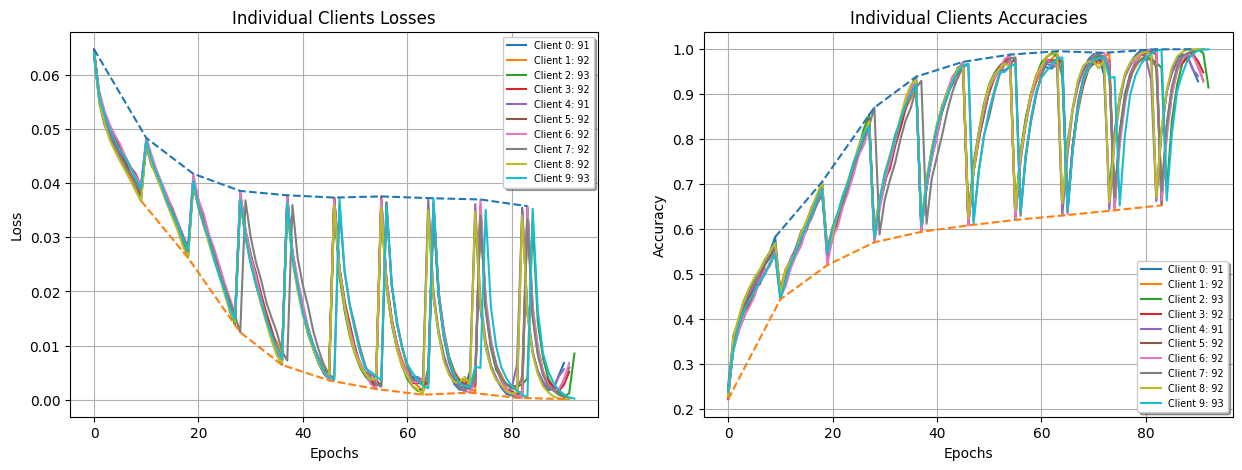

In [21]:
import matplotlib.pyplot as plt


def plot_metrics(client_metrics, rounds: int = 10):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())
    client_ids.sort()

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    round_max_losses: List[Tuple[int, float]] = []
    round_max_accuracy: List[Tuple[int, float]] = []
    round_min_losses: List[Tuple[int, float]] = []
    round_min_accuracy: List[Tuple[int, float]] = []

    for round in range(1, rounds+1):
        metrics_round = [(metrics.epoch, metrics.loss, metrics.accuracy) for metrics_list in client_metrics.values()
                       for metrics in metrics_list if metrics.round == round]
        if metrics_round:
            min_loss = min(metrics_round, key=lambda x: x[1])
            max_loss = max(metrics_round, key=lambda x: x[1])
            round_max_losses.append(max_loss)
            round_min_losses.append(min_loss)
            min_accuracy = min(metrics_round, key=lambda x: x[2])
            max_accuracy = max(metrics_round, key=lambda x: x[2])
            round_max_accuracy.append(max_accuracy)
            round_min_accuracy.append(min_accuracy)

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses,label=f"Client {cid}: {len(strategy.client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_losses]
    max_losses = [round_max[1] for round_max in round_max_losses]
    min_epochs = [round_min[0] for round_min in round_min_losses]
    min_losses = [round_min[1] for round_min in round_min_losses]
    axs[0].plot(max_epochs, max_losses, linestyle='dashed')
    axs[0].plot(min_epochs, min_losses, linestyle='dashed')
    axs[0].set_title("Individual Clients Losses")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend(loc='upper right', fontsize='x-small', shadow=True,)
    axs[0].grid()
    


    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}: {len(client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_accuracy]
    max_accuracies = [round_max[2] for round_max in round_max_accuracy]
    min_epochs = [round_min[0] for round_min in round_min_accuracy]
    min_accuracies = [round_min[2] for round_min in round_min_accuracy]
    axs[1].plot(max_epochs, max_accuracies, linestyle='dashed')
    axs[1].plot(min_epochs, min_accuracies, linestyle='dashed')
    axs[1].set_title("Individual Clients Accuracies")

    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend(loc='lower right',fontsize='x-small', shadow=True,)
    axs[1].grid()

    plt.show()

plot_metrics(strategy.client_metrics)

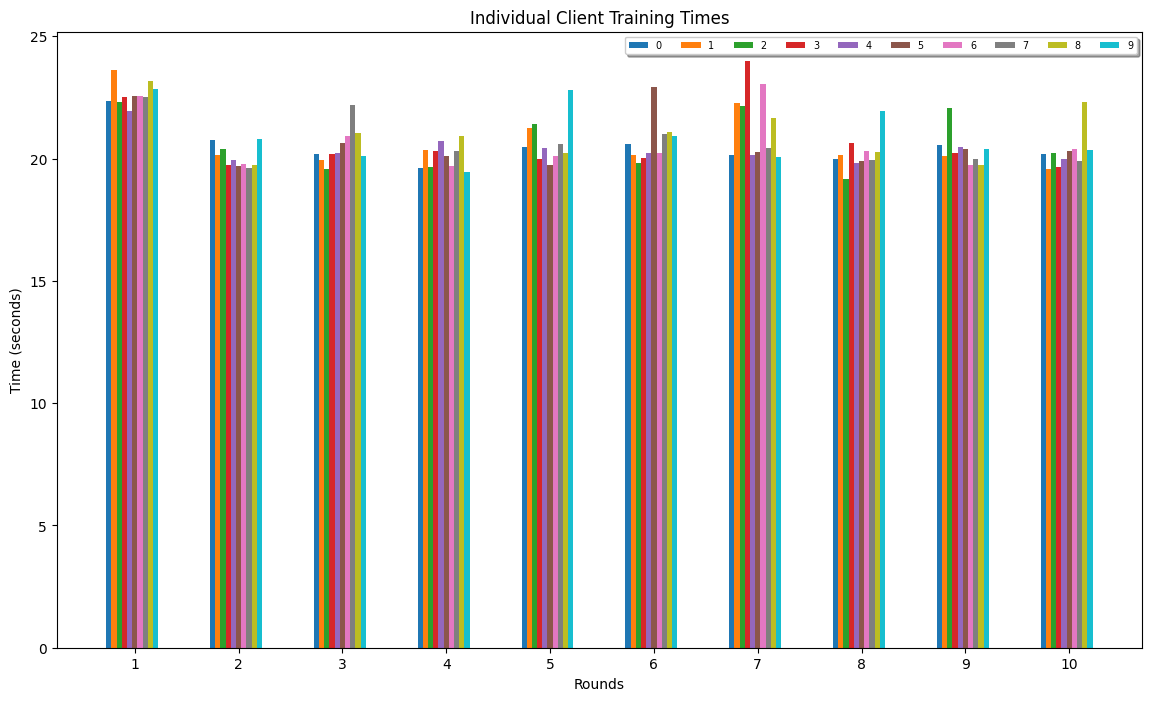

In [22]:
def plot_times(client_training_times):
    client_ids = list(client_training_times.keys())
    client_ids.sort()
    num_rounds = len(client_training_times[client_ids[0]])

    x = np.arange(num_rounds)  # Positions of the bars
    bar_width = 0.05 # Width of bars
    fig, ax = plt.subplots(figsize=(14, 8))

    for i, client_id in enumerate(client_ids):
        times = client_training_times[client_id]
        ax.bar(x + i * bar_width, times, bar_width, label=client_id)

    ax.set_xlabel("Rounds")
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Individual Client Training Times")
    ax.set_xticks(x + bar_width * round(len(client_ids) / 2))
    ax.set_xticklabels(np.arange(1, num_rounds + 1))
    ax.legend(loc='upper right', fontsize='x-small', shadow=True, ncol=len(client_ids))

    plt.show()

plot_times(strategy.client_training_times)

In [23]:
for a in strategy.client_metrics:
    print(f"Client {a} metrics: {len(strategy.client_metrics[a])}")

Client 8 metrics: 92
Client 5 metrics: 92
Client 6 metrics: 92
Client 0 metrics: 91
Client 9 metrics: 93
Client 2 metrics: 93
Client 7 metrics: 92
Client 3 metrics: 92
Client 4 metrics: 91
Client 1 metrics: 92


In [24]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs=10)
        training_time = time.time() - start_time  # Calculate duration
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        print(f"Client {self.cid} loss {loss}")
        print(f"Client {self.cid} accuracy {accuracy}")
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE) #Load Model from here
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [25]:
class FedAvgCustom(fl.server.strategy.FedAvg):
    def __init__(
        self,
        fraction_fit = 1.0,
        fraction_evaluate = 1.0,
        min_fit_clients = 2,
        min_evaluate_clients = 2,
        min_available_clients = 2,
    ):
        super().__init__(fraction_fit = fraction_fit, fraction_evaluate = fraction_evaluate, min_fit_clients = min_fit_clients, min_evaluate_clients = min_evaluate_clients, min_available_clients = min_available_clients)
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}

    def parse_metrics(self, cid: int, server_round: int, metrics: str):
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0))
            self.parse_metrics(client.cid, server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated



In [26]:
strategy_fed_avg = FedAvgCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
    strategy=strategy_fed_avg,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-29 10:21:36,112	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'memory': 74119800218.0, 'accelerator_type:RTX': 1.0, 'object_store_memory': 36051342950.0, 'GPU': 1.0, 'node:127.0.0.1': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=39004) [Client 5] get_parameters
(ClientAppActor pid=39004) [Client 4] fit, config: {}
(ClientAppActor pid=39004) Epoch 0: train loss 0.065959, accuracy 0.197556
(ClientAppActor pid=39004) Epoch 1: train loss 0.057559, accuracy 0.317333
(ClientAppActor pid=26568) [Client 5] fit, config: {}
(ClientAppActor pid=39004) Epoch 2: train loss 0.052355, accuracy 0.387111
(ClientAppActor pid=26568) Epoch 0: train loss 0.064814, accuracy 0.214444
(ClientAppActor pid=39004) Epoch 3: train loss 0.049389, accuracy 0.416000
(ClientAppActor pid=41320) [Client 3] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=34364) Epoch 2: train loss 0.054530, accuracy 0.355333 [repeated 11x across cluster]
(ClientAppActor pid=23208) [Client 8] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=26568) Epoch 5: train loss 0.045931, accuracy 0.465556 [repeated 18x across cluster]
(ClientAppActor pid=39004) [Client 1] fit, config: {}
(ClientAppActor pid=41320) Epoch 5

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=26568) Epoch 9: train loss 0.037443, accuracy 0.573111 [repeated 3x across cluster]
(ClientAppActor pid=26568) [Client 5] evaluate, config: {}
(ClientAppActor pid=26568) Client 5 loss 0.05811029148101807
(ClientAppActor pid=26568) Client 5 accuracy 0.37
(ClientAppActor pid=41320) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=41320) Client 9 loss 0.0594377007484436 [repeated 4x across cluster]
(ClientAppActor pid=41320) Client 9 accuracy 0.356 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=23208) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=23208) Client 3 loss 0.05869103956222534 [repeated 5x across cluster]
(ClientAppActor pid=23208) Client 3 accuracy 0.37 [repeated 5x across cluster]
(ClientAppActor pid=23208) [Client 9] fit, config: {}
(ClientAppActor pid=23208) Epoch 0: train loss 0.049441, accuracy 0.426000
(ClientAppActor pid=41320) [Client 1] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36188) Epoch 1: train loss 0.045597, accuracy 0.470889 [repeated 11x across cluster]
(ClientAppActor pid=34364) [Client 4] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=39004) Epoch 3: train loss 0.038806, accuracy 0.551111 [repeated 17x across cluster]
(ClientAppActor pid=26568) Epoch 7: train loss 0.028904, accuracy 0.671111 [repeated 20x across cluster]
(ClientAppActor pid=23208) Epoch 9: train loss 0.025736, accuracy 0.708222 [repeated 15x across cluster]
(ClientAppActor pid=23208) [

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=26568) [Client 8] evaluate, config: {}
(ClientAppActor pid=26568) Client 8 loss 0.04021316492557526
(ClientAppActor pid=26568) Client 8 accuracy 0.526
(ClientAppActor pid=26568) Epoch 9: train loss 0.024401, accuracy 0.719556
(ClientAppActor pid=26568) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=26568) Client 7 loss 0.04082444155216217 [repeated 4x across cluster]
(ClientAppActor pid=26568) Client 7 accuracy 0.542 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41320) [Client 0] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=41320) Client 0 loss 0.045641918659210204 [repeated 5x across cluster]
(ClientAppActor pid=41320) Client 0 accuracy 0.518 [repeated 5x across cluster]
(ClientAppActor pid=41320) [Client 8] fit, config: {}
(ClientAppActor pid=41320) Epoch 0: train loss 0.038907, accuracy 0.557556
(ClientAppActor pid=26568) [Client 9] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=39004) Epoch 0: train loss 0.039992, accuracy 0.544222 [repeated 11x across cluster]
(ClientAppActor pid=29188) [Client 6] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=26568) Epoch 3: train loss 0.029122, accuracy 0.662667 [repeated 17x across cluster]
(ClientAppActor pid=36188) Epoch 4: train loss 0.024733, accuracy 0.720000 [repeated 19x across cluster]
(ClientAppActor pid=41320) Epoch 9: train loss 0.011844, accuracy 0.872444 [repeated 14x across cluster]
(ClientAppActor pid=41320)

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=30708) [Client 8] evaluate, config: {}
(ClientAppActor pid=30708) Client 8 loss 0.0449543319940567
(ClientAppActor pid=30708) Client 8 accuracy 0.58
(ClientAppActor pid=30708) Epoch 9: train loss 0.010919, accuracy 0.885111 [repeated 2x across cluster]
(ClientAppActor pid=26568) [Client 2] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=39004) Client 5 loss 0.04837859988212585 [repeated 4x across cluster]
(ClientAppActor pid=39004) Client 5 accuracy 0.584 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=30708) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=30708) Client 7 loss 0.04540958034992218 [repeated 5x across cluster]
(ClientAppActor pid=30708) Client 7 accuracy 0.58 [repeated 5x across cluster]
(ClientAppActor pid=30708) [Client 9] fit, config: {}
(ClientAppActor pid=30708) Epoch 0: train loss 0.038073, accuracy 0.570000
(ClientAppActor pid=23208) [Client 5] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=39004) Epoch 0: train loss 0.036890, accuracy 0.599333 [repeated 10x across cluster]
(ClientAppActor pid=36188) [Client 7] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=34364) Epoch 4: train loss 0.016683, accuracy 0.814222 [repeated 18x across cluster]
(ClientAppActor pid=39004) Epoch 5: train loss 0.012528, accuracy 0.864000 [repeated 20x across cluster]
(ClientAppActor pid=30708) [Client 6] fit, config: {}
(ClientAppActor pid=36188) Epoch 6: train loss 0.009966, accuracy 0.900444 [rep

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41320) [Client 6] evaluate, config: {}
(ClientAppActor pid=41320) Client 6 loss 0.05804413175582886
(ClientAppActor pid=41320) Client 6 accuracy 0.58
(ClientAppActor pid=41320) Epoch 9: train loss 0.004571, accuracy 0.960222
(ClientAppActor pid=23208) [Client 8] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=39004) Client 4 loss 0.05963247013092041 [repeated 4x across cluster]
(ClientAppActor pid=39004) Client 4 accuracy 0.558 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=26568) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=26568) Client 1 loss 0.060286003708839415 [repeated 5x across cluster]
(ClientAppActor pid=26568) Client 1 accuracy 0.574 [repeated 5x across cluster]
(ClientAppActor pid=26568) [Client 5] fit, config: {}
(ClientAppActor pid=26568) Epoch 0: train loss 0.037629, accuracy 0.604667
(ClientAppActor pid=30708) [Client 2] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29188) Epoch 2: train loss 0.019830, accuracy 0.781556 [repeated 11x across cluster]
(ClientAppActor pid=34364) [Client 3] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=36188) Epoch 4: train loss 0.011055, accuracy 0.883333 [repeated 17x across cluster]
(ClientAppActor pid=39004) Epoch 4: train loss 0.011495, accuracy 0.879778 [repeated 19x across cluster]
(ClientAppActor pid=26568) Epoch 9: train loss 0.002910, accuracy 0.974222 [repeated 14x across cluster]
(ClientAppActor pid=26568)

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29188) [Client 8] evaluate, config: {}
(ClientAppActor pid=29188) Client 8 loss 0.05995614969730377
(ClientAppActor pid=29188) Client 8 accuracy 0.616
(ClientAppActor pid=29188) Epoch 9: train loss 0.002648, accuracy 0.979778 [repeated 2x across cluster]
(ClientAppActor pid=39004) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=34364) Client 1 loss 0.06926939034461975 [repeated 3x across cluster]
(ClientAppActor pid=34364) Client 1 accuracy 0.574 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29188) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=36188) Client 0 loss 0.0681596450805664 [repeated 5x across cluster]
(ClientAppActor pid=36188) Client 0 accuracy 0.574 [repeated 5x across cluster]
(ClientAppActor pid=29188) [Client 3] fit, config: {}
(ClientAppActor pid=29188) Client 3 loss 0.059493403911590574
(ClientAppActor pid=29188) Client 3 accuracy 0.584
(ClientAppActor pid=29188) Epoch 0: train loss 0.039209, accuracy 0.593778
(ClientAppActor pid=30708) [Client 8] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=34364) Epoch 0: train loss 0.037221, accuracy 0.621556 [repeated 11x across cluster]
(ClientAppActor pid=41320) [Client 5] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=30708) Epoch 3: train loss 0.010884, accuracy 0.882889 [repeated 17x across cluster]
(ClientAppActor pid=34364) Epoch 5: train loss 0.005963, accuracy 0.944222 [repeated 20x across cluster]
(ClientAppActor pid=

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=23208) Epoch 9: train loss 0.005104, accuracy 0.948222 [repeated 5x across cluster]
(ClientAppActor pid=23208) [Client 9] evaluate, config: {}
(ClientAppActor pid=23208) Client 9 loss 0.07105306172370911
(ClientAppActor pid=23208) Client 9 accuracy 0.546
(ClientAppActor pid=41320) [Client 1] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=29188) Client 2 loss 0.07728402614593506 [repeated 4x across cluster]
(ClientAppActor pid=29188) Client 2 accuracy 0.56 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=23208) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=23208) Client 0 loss 0.07326698160171509 [repeated 5x across cluster]
(ClientAppActor pid=23208) Client 0 accuracy 0.564 [repeated 5x across cluster]
(ClientAppActor pid=23208) [Client 0] fit, config: {}
(ClientAppActor pid=23208) Epoch 0: train loss 0.037497, accuracy 0.636444
(ClientAppActor pid=30708) [Client 7] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=41320) Epoch 2: train loss 0.014179, accuracy 0.846000 [repeated 11x across cluster]
(ClientAppActor pid=39004) [Client 5] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=29188) Epoch 4: train loss 0.005122, accuracy 0.956667 [repeated 17x across cluster]
(ClientAppActor pid=23208) Epoch 7: train loss 0.001602, accuracy 0.990222 [repeated 19x across cluster]
(ClientAppActor pid=23208) Epoch 9: train loss 0.000266, accuracy 1.000000 [repeated 15x across cluster]
(ClientAppActor pid=23208) 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=41320) [Client 4] evaluate, config: {}
(ClientAppActor pid=41320) Client 4 loss 0.07304000043869019
(ClientAppActor pid=41320) Client 4 accuracy 0.532
(ClientAppActor pid=41320) Epoch 9: train loss 0.005674, accuracy 0.936222
(ClientAppActor pid=41320) [Client 7] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=23208) Client 2 loss 0.08004093170166016 [repeated 4x across cluster]
(ClientAppActor pid=23208) Client 2 accuracy 0.534 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=39004) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=39004) Client 9 loss 0.07274214172363282 [repeated 5x across cluster]
(ClientAppActor pid=39004) Client 9 accuracy 0.53 [repeated 5x across cluster]
(ClientAppActor pid=39004) [Client 1] fit, config: {}
(ClientAppActor pid=39004) Epoch 0: train loss 0.035982, accuracy 0.651111
(ClientAppActor pid=30708) [Client 2] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=30708) Epoch 1: train loss 0.017198, accuracy 0.809556 [repeated 12x across cluster]
(ClientAppActor pid=29188) [Client 6] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=39004) Epoch 5: train loss 0.002013, accuracy 0.988000 [repeated 19x across cluster]
(ClientAppActor pid=34364) Epoch 7: train loss 0.001780, accuracy 0.988222 [repeated 17x across cluster]
(ClientAppActor pid=39004) [Client 3] fit, config: {}
(ClientAppActor pid=29188) Epoch 6: train loss 0.001637, accuracy 0.990889 [rep

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34364) Epoch 9: train loss 0.005108, accuracy 0.942222 [repeated 5x across cluster]
(ClientAppActor pid=34364) [Client 7] evaluate, config: {}
(ClientAppActor pid=34364) Client 7 loss 0.0716484124660492
(ClientAppActor pid=34364) Client 7 accuracy 0.58
(ClientAppActor pid=30708) [Client 8] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=26568) Client 5 loss 0.07465896129608154 [repeated 4x across cluster]
(ClientAppActor pid=26568) Client 5 accuracy 0.588 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29188) [Client 6] fit, config: {}
(ClientAppActor pid=29188) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29188) Client 3 loss 0.07163643002510071 [repeated 5x across cluster]
(ClientAppActor pid=29188) Client 3 accuracy 0.576 [repeated 5x across cluster]
(ClientAppActor pid=29188) Epoch 0: train loss 0.036741, accuracy 0.653778
(ClientAppActor pid=30708) [Client 3] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=34364) Epoch 2: train loss 0.008941, accuracy 0.905111 [repeated 9x across cluster]
(ClientAppActor pid=36188) [Client 4] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=26568) Epoch 4: train loss 0.002748, accuracy 0.981333 [repeated 19x across cluster]
(ClientAppActor pid=34364) Epoch 7: train loss 0.002979, accuracy 0.969556 [repeated 20x across cluster]
(ClientAppActor pid=29188) [Client 5] fit, config: {}
(ClientAppActor pid=34364) Epoch 9: train loss 0.005950, accuracy 0.935556 [rep

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34364) Epoch 9: train loss 0.010145, accuracy 0.891778 [repeated 5x across cluster]
(ClientAppActor pid=34364) [Client 7] evaluate, config: {}
(ClientAppActor pid=34364) Client 7 loss 0.07176122212409973
(ClientAppActor pid=34364) Client 7 accuracy 0.576
(ClientAppActor pid=36188) [Client 8] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=23208) Client 4 loss 0.07683312749862671 [repeated 4x across cluster]
(ClientAppActor pid=23208) Client 4 accuracy 0.546 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=36188) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=36188) Client 5 loss 0.07421539449691772 [repeated 5x across cluster]
(ClientAppActor pid=36188) Client 5 accuracy 0.598 [repeated 5x across cluster]
(ClientAppActor pid=36188) [Client 3] fit, config: {}
(ClientAppActor pid=36188) Epoch 0: train loss 0.035600, accuracy 0.655556
(ClientAppActor pid=23208) [Client 4] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=30708) Epoch 2: train loss 0.008084, accuracy 0.918222 [repeated 10x across cluster]
(ClientAppActor pid=26568) [Client 8] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=34364) Epoch 3: train loss 0.003866, accuracy 0.968000 [repeated 18x across cluster]
(ClientAppActor pid=23208) Epoch 6: train loss 0.003601, accuracy 0.965333 [repeated 20x across cluster]
(ClientAppActor pid=36188) [Client 6] fit, config: {}
(ClientAppActor pid=30708) Epoch 9: train loss 0.006852, accuracy 0.929333 [re

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=30708) Epoch 9: train loss 0.008285, accuracy 0.913556 [repeated 5x across cluster]
(ClientAppActor pid=30708) [Client 3] evaluate, config: {}
(ClientAppActor pid=30708) Client 3 loss 0.08514868712425232
(ClientAppActor pid=30708) Client 3 accuracy 0.574
(ClientAppActor pid=39004) [Client 8] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=39004) Client 8 loss 0.08204638195037842 [repeated 4x across cluster]
(ClientAppActor pid=39004) Client 8 accuracy 0.6 [repeated 4x across cluster]
(ClientAppActor pid=30708) [Client 6] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 635.65s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.05896618738174438
INFO :      		round 2: 0.04265907278060913
INFO :      		round 3: 0.04916311718225479
INFO :      		round 4: 0.05815865513086319
INFO :      		round 5: 0.06518904849290848
INFO :      		round 6: 0.07056532269716262
INFO :      		round 7: 0.07186919238567352
INFO :      		round 8: 0.07640157685279846
INFO :      		round 9: 0.07575862201452255
INFO :      		round 10: 0.08747067303657532
INFO :      


(ClientAppActor pid=30708) Client 6 loss 0.08743568062782288 [repeated 4x across cluster]
(ClientAppActor pid=30708) Client 6 accuracy 0.574 [repeated 4x across cluster]


History (loss, distributed):
	round 1: 0.05896618738174438
	round 2: 0.04265907278060913
	round 3: 0.04916311718225479
	round 4: 0.05815865513086319
	round 5: 0.06518904849290848
	round 6: 0.07056532269716262
	round 7: 0.07186919238567352
	round 8: 0.07640157685279846
	round 9: 0.07575862201452255
	round 10: 0.08747067303657532

In [30]:
import matplotlib.pyplot as plt


def plot_metricss(client_metrics, rounds: int = 10):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())
    client_ids.sort()

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    round_max_losses: List[Tuple[int, float]] = []
    round_max_accuracy: List[Tuple[int, float]] = []
    round_min_losses: List[Tuple[int, float]] = []
    round_min_accuracy: List[Tuple[int, float]] = []

    for round in range(1, rounds+1):
        metrics_round = [(metrics.epoch, metrics.loss, metrics.accuracy) for metrics_list in client_metrics.values()
                       for metrics in metrics_list if metrics.round == round]
        if metrics_round:
            min_loss = min(metrics_round, key=lambda x: x[1])
            max_loss = max(metrics_round, key=lambda x: x[1])
            round_max_losses.append(max_loss)
            round_min_losses.append(min_loss)
            min_accuracy = min(metrics_round, key=lambda x: x[2])
            max_accuracy = max(metrics_round, key=lambda x: x[2])
            round_max_accuracy.append(max_accuracy)
            round_min_accuracy.append(min_accuracy)

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses,label=f"Client {cid}: {len(strategy_fed_avg.client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_losses]
    max_losses = [round_max[1] for round_max in round_max_losses]
    min_epochs = [round_min[0] for round_min in round_min_losses]
    min_losses = [round_min[1] for round_min in round_min_losses]
    axs[0].plot(max_epochs, max_losses, linestyle='dashed')
    axs[0].plot(min_epochs, min_losses, linestyle='dashed')
    axs[0].set_title("Individual Clients Losses")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Loss")
    axs[0].legend(loc='upper right', fontsize='x-small', shadow=True,)
    axs[0].grid()
    


    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}: {len(client_metrics[cid])}")

    max_epochs = [round_max[0] for round_max in round_max_accuracy]
    max_accuracies = [round_max[2] for round_max in round_max_accuracy]
    min_epochs = [round_min[0] for round_min in round_min_accuracy]
    min_accuracies = [round_min[2] for round_min in round_min_accuracy]
    axs[1].plot(max_epochs, max_accuracies, linestyle='dashed')
    axs[1].plot(min_epochs, min_accuracies, linestyle='dashed')
    axs[1].set_title("Individual Clients Accuracies")

    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend(loc='lower right',fontsize='x-small', shadow=True,)
    axs[1].grid()

    plt.show()

#plot_metrics(strategy.client_metrics)

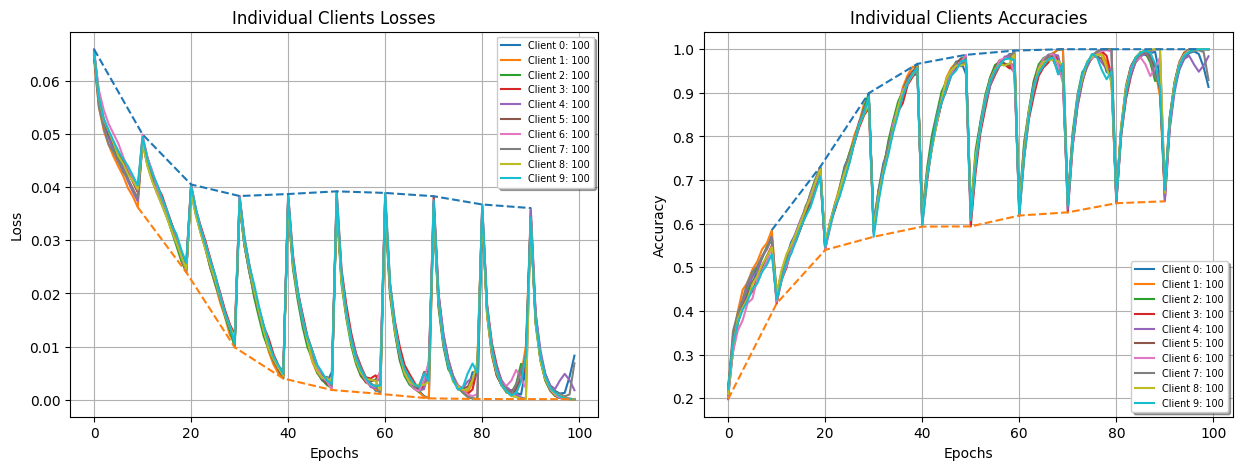

In [33]:
plot_metricss(strategy_fed_avg.client_metrics)

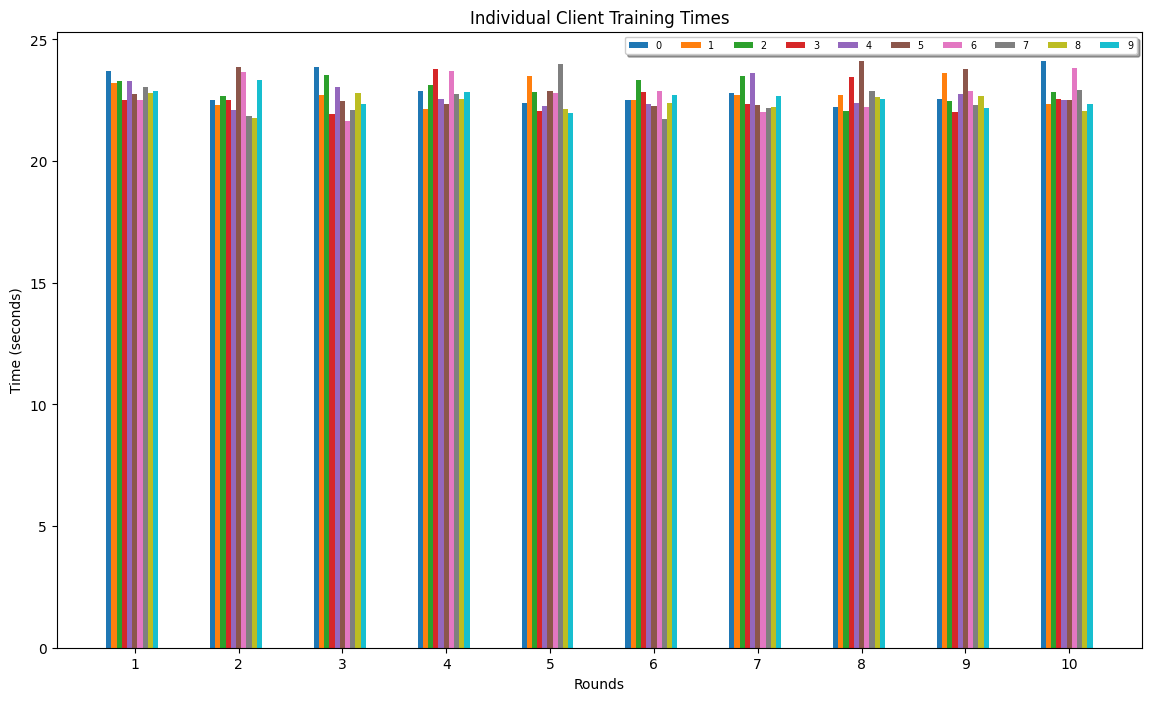

In [32]:
plot_times(strategy_fed_avg.client_training_times)